In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import os
import sys
sys.path.append("../lib")
from dataUtils import *
import cPickle as pickle
import cv2
from collections import Counter
from scipy.interpolate import UnivariateSpline


In [13]:
#ClassFile = "../Logs/classes.json"
ClassFile = "../Logs/english_label.txt"

#vineScores = "../Logs/sampled_vine_sentibank_final.csv"
vineScores = "/work/sagarj/Work/InstaCrawl/Logs/insta6000_probs.csv"
#"../Logs/insta2016_probs.csv"
#selfieScores = "../Logs/selfieSentibankProbs.csv"
sentibank_scores = "../Logs/sentibank_baseline_final.csv"

#vineANPs = "../Logs/sampled_vine_ANPS_final.pk"
vineANPs = "/work/sagarj/Work/work_ipython/instaCrawl/Logs/insta6000_ANPs.pk"
#"../Logs/insta2016_ANPs.pk"
#selfiePaths = "../Logs/selfiePaths.txt"

imageNetObjs = "../Logs/sampledvineImagenetObjs2015_1.pk"

#selfiePopularityFile = "../Logs/selfie_dataset.txt"

root = "../vinedata/Data/"

visitedList = "../Logs/sampledVids.data"

# sentimentFile = "../Logs/ANP_Sentiments.txt"

color_features = "../Logs/color_features_sampled_ordered.csv"

sampled_img_list = "../Logs/sampled_sentibank_image.txt"

revisedSentimentFile = "../Logs/revised_ANP_sentiments.csv"

In [5]:
#Load the Sentibank scores for both selfies and Vines
vineProbs = np.loadtxt(vineScores, delimiter=',')
sentibank_baseline = np.loadtxt(sentibank_scores, delimiter=',')

In [6]:
print vineProbs.shape , sentibank_baseline.shape

(51422, 4342) (5000, 2089)


In [7]:
def get_ANP_ID_List(pickleList):
    ANPs = []
    IDs = []
    for line in pickleList:
        ids = line.split(',')[0].split('/')[5].split('+')[0]
        IDs.append(ids)
        ANPs.append(line.split(',')[1])
    return IDs , ANPs

def get_vid_senti(pickle , index):
    oldId = pickle[index].split(',')[0].split('/')[5].split('+')[0]
    seqDict = dict()
    indexList = []
    sequence = pickle[index].split(',')[0].split('/')[5].split('+')[-1].split('.')[0]
    seqDict[int(sequence)] = str(pickle[index].split(',')[1])
    indexList.append(index)
    index+=1
    #print index
    while (index < len(pickle) and (pickle[index].split(',')[0].split('/')[5].split('+')[0] == oldId)):
        sequence = pickle[index].split(',')[0].split('/')[5].split('+')[1].split('.')[0]
        seqDict[int(sequence)] = str(pickle[index].split(',')[1])
        indexList.append(index)
        index += 1
    seqDict['indexList'] = indexList
    return seqDict , oldId , index
    
def get_VID_ANP_List(pickle):
    megaDict = dict()
    i = 0
    print len(pickle)
    while i < len(pickle):           
        subDict , postId , i = get_vid_senti(pickle , i)
        megaDict[postId] = subDict
    return megaDict


def pruneMegaDict(megadict , filterindices):
    filteredList = dict()
    for entry in megadict:
        commns = set(megadict[entry]['indexList']).intersection(filterindices)
        #if len(commns) >= 4:
        filteredList[entry] = megadict[entry]
    return filteredList


In [8]:
image_list =[]
with open(sampled_img_list) as f:
    image_list = f.readlines()

true_labels = []
for line in image_list:
    label = line.split('/')[5]
    true_labels.append(label)
    
# f = open(ClassFile ,'r')
# sentibankClasses = json.load(f)
# f.close()

f = open(ClassFile ,'r')
sentibankClasses = f.readlines()
f.close()

In [9]:
sentibank_probs = np.zeros(len(sentibank_baseline))
detected_labels = []
for i in range(sentibank_probs.shape[0]):
    sentibank_probs[i] = sentibank_baseline[i].max()
    detected_labels.append(str(sentibankClasses[np.argmax(sentibank_baseline[i])]))
    
print np.median(sentibank_probs), sentibank_probs.var(), sentibank_probs.mean()

0.0718716159463 0.0234088881327 0.125452709451


In [10]:
maxVecs = np.zeros(len(vineProbs))
for i in range(len(vineProbs)):
    maxVecs[i] = np.max(vineProbs[i])
print np.mean(maxVecs) , np.median(maxVecs) , np.var(maxVecs)

0.0219929797195 0.0156378522515 0.000550136769749


In [11]:
curatedProbs_index = []
for i in range(len(vineProbs)):
    if (vineProbs[i].max() > 0.00001):
        curatedProbs_index.append(i)

        
print len(curatedProbs_index)

51422


In [14]:

vineList = readLists(vineANPs)
objList = readLists(imageNetObjs)
print vineList[1000]

/datasets/sagarj/instaSample6000/finesamples/02rK6Zod25+10.jpg,global_business,0.010672,great_performance,0.00892509,interactive_media,0.00888701,funny_jokes,0.00871502,global_impact,0.0083625


In [15]:
idList, anpList = get_ANP_ID_List(vineList)

In [16]:
print idList[1000] , anpList [1000]

02rK6Zod25 global_business


In [17]:
sentidict0 = readSentiments()
sentidict = readRevisedSentiments()

In [18]:
print len(sentidict)

4421


In [19]:
# f = open('sentibankANP.csv', 'wb')
# for k,v in sentidict0.iteritems():
#     f.write(k+','+str(v)+'\n')
#     #print k , v
# f.close()

In [20]:
megaDict = get_VID_ANP_List(vineList)

51422


In [21]:
#megaDict[1281867050901532672]['indexList']

In [22]:
filteredDict = pruneMegaDict(megaDict, curatedProbs_index)

In [23]:
print len(filteredDict)

6411


In [81]:
filteredDict.keys()[1]

'wmst8TEsZF'

In [25]:
postIds = []
for line in vineList:
    arr = line.split('/')
    postIds.append(arr[5].split('+')[0])

In [26]:
letter_counts = Counter(postIds)

'0AfI_KPQft'

In [27]:
len(letter_counts)

6411

In [82]:
#Vectors for filtered videos
sentiList = []
medianSenti = dict()
for entry in filteredDict:
    senti = []
    indexRange = len(filteredDict[entry]['indexList']) + 1
    for i in range(1 , indexRange):
        senti.append(sentidict[filteredDict[entry][i]] if (filteredDict[entry][i] in sentidict) else 0.0)
    medianSenti[entry] = np.median(senti)
    sentiList.append(senti)

In [88]:
# with open("instaMedianSenti.csv", 'wb') as f:
#     for k in medianSenti:
#         line = k + "," + str(medianSenti[k]) + '\n'
#         f.write(line)    
# f.close()
        

In [29]:
a = [len(x) for x in sentiList ]

In [30]:
sentiList[1]

[3.0, 4.4, 4.8, 3.2, 3.2, 3.2]

In [32]:
print np.median(a)

6.0


In [98]:
thirdsMatrix = np.zeros((len(sentiList),3))

In [99]:
thirdsMax = [0 , 0 , 0]
thirdsMin = [0 , 0 , 0 ]

In [100]:
for i in range(len(sentiList)):
    quo = int(len(sentiList[i])/3)
    thirdsMatrix[i][0] = np.median(sentiList[i][:1*quo])
    thirdsMatrix[i][1] = np.median(sentiList[i][1*quo:2*quo])
    thirdsMatrix[i][2] = np.median(sentiList[i][2*quo:])
    aMax = np.argmax(thirdsMatrix[i])
    aMin = np.argmin(thirdsMatrix[i])
    if thirdsMatrix[i][aMax] - thirdsMatrix[i][aMin] > 1.5:
        thirdsMax[aMax]+=1
        thirdsMin[aMin]+=1

In [101]:
print thirdsMax , thirdsMin

[397, 275, 311] [360, 343, 280]


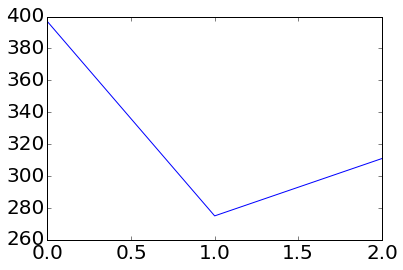

In [102]:
plt.plot(thirdsMax)

In [38]:
np.median([len(vec) for vec in sentiList])

6.0

In [76]:
sentiList[1000]

[3.8,
 1.8,
 4.2,
 4.8,
 3.8,
 4.4,
 5.0,
 3.8,
 5.0,
 4.2,
 4.2,
 4.2,
 4.2,
 4.2,
 4.2,
 4.2,
 4.2,
 4.2]

In [70]:
#Normalize Youtube video lengths to 10 seconds
sentiMatrix = []
dims = 2
for element in sentiList: 
    if len(element) > dims:
        temp = []
        quo = len(element)/dims
        mod = len(element)%dims
        if mod >= dims/2:
            newVec = [element[-1] for x in range(dims - mod)]
            element.extend(newVec)
        else:
            element = element[:quo*dims]
        quo = len(element)/dims
        mod = len(element)%dims
        starts = [a*quo for a in range(0,4)]
        ends = [b*quo for b in range(1,5)]
        for start, end in zip(starts , ends):
            temp.append(np.median(element[start:end]))
        sentiMatrix.append(temp)

In [71]:
a = [len(x) for x in sentiMatrix ]
#print a

In [72]:
senti_matrix = np.asarray(sentiMatrix)
print senti_matrix.shape

(6391, 4)


In [51]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import minkowski

In [53]:
centroid_list = []
id_list = []
for i in range(1 , 12):
    centroids,_ = kmeans(senti_matrix,i)
    idx,_ = vq(senti_matrix,centroids)
    centroid_list.append(centroids)
    id_list.append(idx)

In [54]:
SSE_values = np.zeros(len(id_list))
for i in range(len(centroid_list)):
    for j in range(len(centroid_list[i])):
        vecs = senti_matrix[id_list[i]==j,:]
        #print vecs.shape
        cent = centroid_list[i][j]
        SSE_1 = 0.0
        for vec in vecs:
            SSE_1 = SSE_1 + minkowski(vec,cent,2)
        SSE_values[j] = SSE_values[j] + SSE_1
for i in range(len(SSE_values)):
    SSE_values[i] = SSE_values[i]/(i+1)

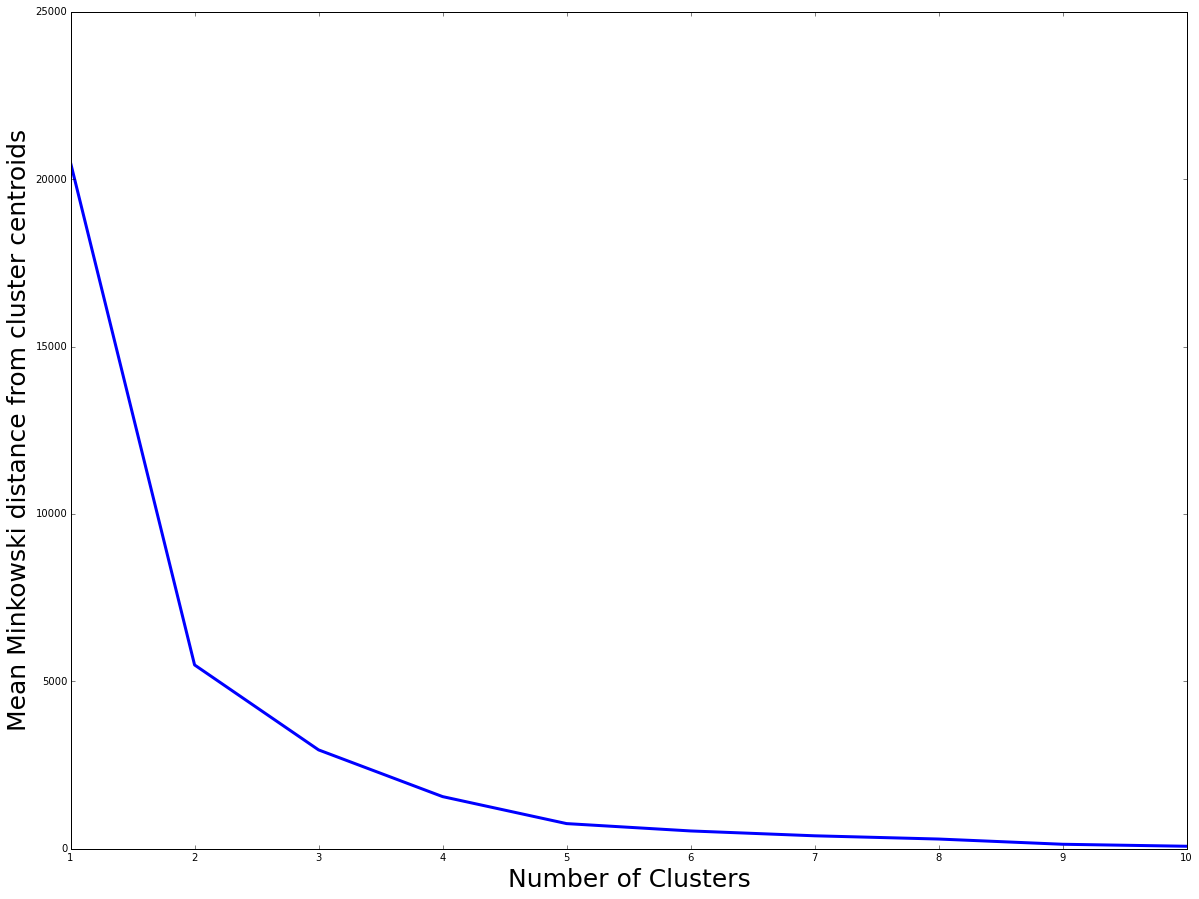

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
x = np.arange(1,11)
plt.plot(x,SSE_values[:10] ,linewidth = 3.0)
plt.xlabel("Number of Clusters", fontsize = 25)
plt.ylabel("Mean Minkowski distance from cluster centroids", fontsize = 25)
plt.show()

In [56]:
centroid_final,_ = kmeans(senti_matrix,3)
idx_final,_ = vq(senti_matrix,centroid_final)

In [57]:
vecs1 = senti_matrix[idx_final==0,:]
vecs2 = senti_matrix[idx_final==1,:]
vecs3 = senti_matrix[idx_final==2,:]
vecs4 = senti_matrix[idx_final==3,:]
vecs5 = senti_matrix[idx_final==4,:]
vecs6 = senti_matrix[idx_final==5,:]
vecs7 = senti_matrix[idx_final==6,:]
#senti_matrix[idx_final==0]

In [58]:
print len(vecs1)
print len(vecs2)
print len(vecs3)
print len(vecs4)
print len(vecs5)
print len(vecs6)


2118
1103
2840
0
0
0


In [59]:
print centroid_final

[[ 4.29550062  4.29442707  4.44270594  4.47283354]
 [ 2.98500213  2.89237445  2.54226202  2.34809385]
 [ 3.496281    3.50318135  3.55928851  3.60464928]]


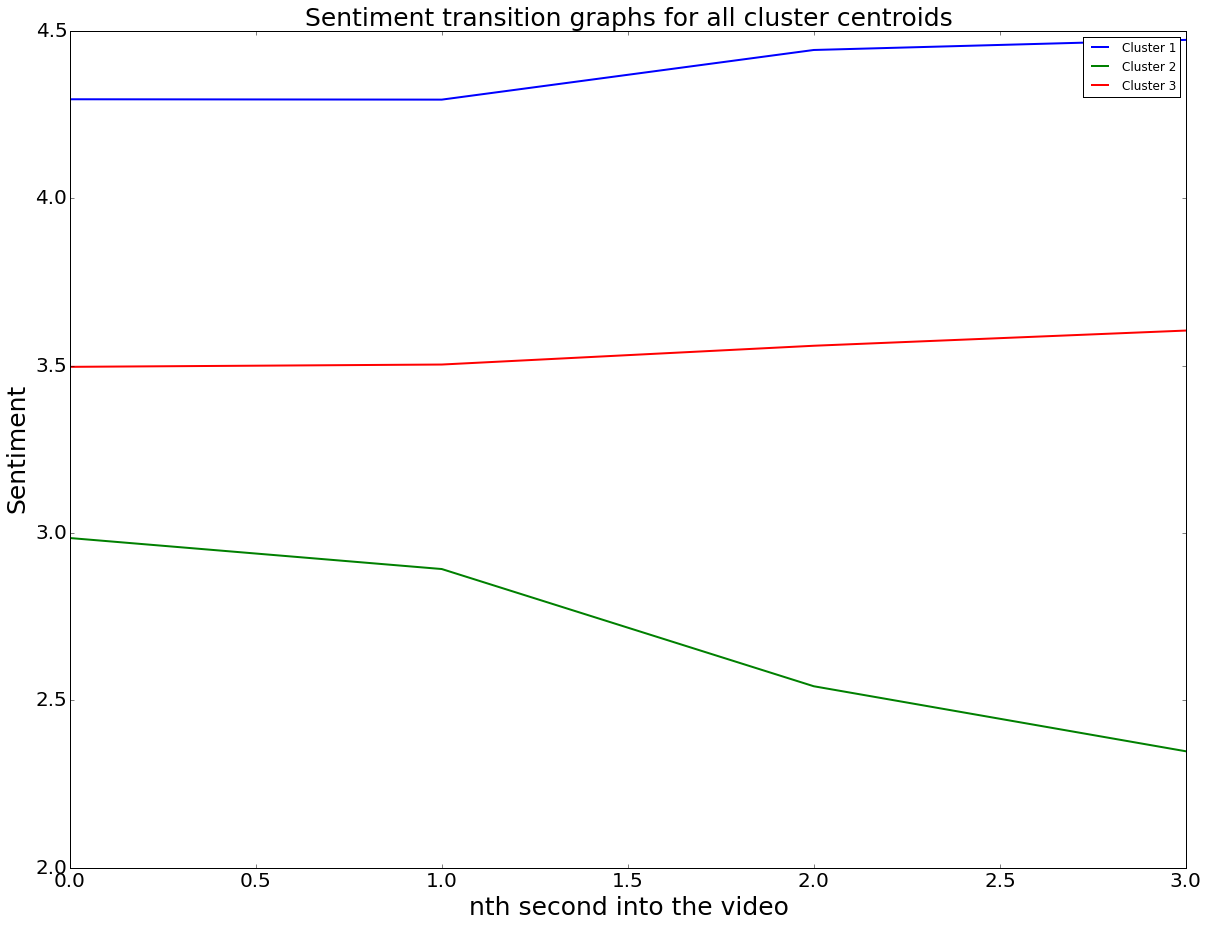

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.title("Sentiment transition graphs for all cluster centroids", fontsize = 25)
plt.plot(centroid_final[0], linewidth = 2.0)
plt.plot(centroid_final[1], linewidth = 2.0)
plt.plot(centroid_final[2], linewidth = 2.0)
# plt.plot(centroid_final[3], linewidth = 2.0)
#plt.plot(centroid_final[4], linewidth = 2.0 )
#plt.plot(centroid_final[5], linewidth = 2.0 )

plt.xlabel("nth second into the video", fontsize = 25)
plt.ylabel("Sentiment", fontsize = 25)
plt.legend(['Cluster 1', 'Cluster 2' , 'Cluster 3' 
            ,'Cluster 4'
            ,'Cluster 5'
            ,'Cluster 6'
            ,'Cluster 7'
            
           ])
plt.show()

In [77]:
filteredDict[filteredDict.keys()[1]]

{1: 'electric_cars',
 2: 'cool_office',
 3: 'blessed_life',
 4: 'fit_club',
 5: 'fit_club',
 6: 'fit_club',
 'indexList': [47014, 47015, 47016, 47017, 47018, 47019]}